# Multinomial Naïves Bayes

In [1]:
#!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,make_scorer,make_scorer, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
reviews_df = pd.read_csv("reviews_preproc.csv")
reviews_df = reviews_df[["Texto Preprocesado","Valoración"]]
reviews_df = reviews_df.rename(columns={"Texto Preprocesado": "Texto"})

In [4]:
#Asignamos la polaridad en función de la valoración númerica
reviews_df['Polaridad'] = reviews_df['Valoración'].apply(lambda c: 'Positivo' if c > 3  else('Negativo' if c < 3 else 'Neutro'))

In [5]:
#Tomamos la polaridad negativa y positiva
reviews_df = reviews_df[(reviews_df['Polaridad'] =='Positivo') | 
          (reviews_df['Polaridad'] == 'Negativo')] 

In [6]:
#Tomamos la muestra para nuestra experimentación (50000)
reviews_positivo_df = reviews_df[reviews_df['Polaridad'] == "Positivo"]
reviews_positivo_df = reviews_positivo_df.dropna()
reviews_positivo_df = reviews_positivo_df.sample(n = 25000)

reviews_negativo_df = reviews_df[reviews_df['Polaridad'] == "Negativo"]
reviews_negativo_df = reviews_negativo_df.dropna()
reviews_negativo_df = reviews_negativo_df.sample(n = 25000)

reviews_df = pd.concat([reviews_positivo_df,reviews_negativo_df])
reviews_df

,Texto,Valoración,Polaridad
80529,rich abund food varieti choos excel treatment,5,Positivo
128569,ideal mid morn coffe vermouth noon serv great ...,5,Positivo
376921,tabl overlook beach beauti locat extrem friend...,5,Positivo
291893,alway attent good servic best cuisin,5,Positivo
31098,excel food servic luckili book tabl saturday n...,5,Positivo
...,...,...,...
204359,food averag servic realli bad need ask 2 time ...,1,Negativo
157775,fatal went dinner went wrote told us kitchen o...,1,Negativo
51713,guid rather poor review expens sweet addit pur...,1,Negativo
64180,put star put zero truth rate food servic appar...,1,Negativo


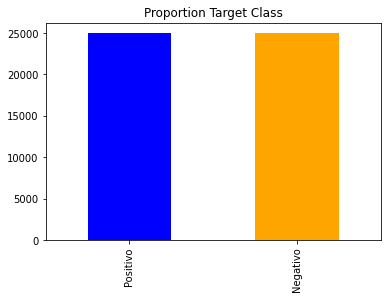

In [7]:
count_class=pd.value_counts(reviews_df["Polaridad"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [8]:
print('Positivo', round(reviews_df['Polaridad'].value_counts()['Positivo']/len(reviews_df) * 100), '%')
print('Negativo', round(reviews_df['Polaridad'].value_counts()['Negativo']/len(reviews_df) * 100), '%')

Positivo 50 %
Negativo 50 %


In [9]:
#Trabajamos con datos numericos (1=Positivo, 0=Negativo)
reviews_df['Texto'] = reviews_df['Texto'].astype(str)
reviews_df['Polaridad'] = reviews_df['Polaridad'].replace(['Positivo', 'Negativo'], [1, 0]) #!!!!!!
#reviews_df

In [10]:
main_text = reviews_df['Texto']
target = reviews_df['Polaridad']

print(len(main_text))
print(len(target))

50000
50000


In [11]:
#Vectorizamos la Polaridad
n_classes = np.unique(target)
n_classes

array([0, 1], dtype=int64)

In [12]:
#Vectorizamos y Definimos los conjuntos de datos de entrenamiento y prueba
cv = CountVectorizer()

train_data,test_data = train_test_split(reviews_df,train_size=0.9,random_state=0)

X_train = cv.fit_transform(train_data['Texto'])
y_train = train_data['Polaridad']
X_test = cv.transform(test_data['Texto'])
y_test = test_data['Polaridad']

In [13]:
#Instanciamos la clase MultinomialNB (parámetros por defecto)
nb = MultinomialNB() #alpha=1.0, class_prior=None, fit_prior=True

In [14]:
#Definimos una matriz con los hiperparámetros a utilizar en la experimentación
params = {'alpha': [0,0.01, 0.1, 0.5, 1.0, 10.0 ],
          'fit_prior': [True, False],
          'class_prior': [None, [0.5,]* len(n_classes), ]
         }
# Define las metricas a obtener
scoring = {'accuracy': make_scorer(accuracy_score),
 'f1': make_scorer(f1_score, pos_label=1),
 'roc_auc': make_scorer(roc_auc_score)}

# Entrena los datos
multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params,scoring=scoring,refit='accuracy', n_jobs=-1, cv=5, verbose=10)
multinomial_nb_grid.fit(X_train,y_train)

# Predice los datos de test
y_pred = multinomial_nb_grid.predict(X_test)

print('Best Accuracy Through Grid Search : {:.3f}'.format(multinomial_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(multinomial_nb_grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Accuracy Through Grid Search : 0.927
Best Parameters : {'alpha': 0.5, 'class_prior': None, 'fit_prior': False}



In [15]:
#Imprimimos métricas obtenidas
for accuracy, f1, roc_auc, params in zip(multinomial_nb_grid.cv_results_['mean_test_accuracy'], 
                             multinomial_nb_grid.cv_results_['mean_test_f1'], multinomial_nb_grid.cv_results_['mean_test_roc_auc'], 
                             multinomial_nb_grid.cv_results_['params']):
       print("%0.5f %0.5f %0.5f for %r" % (accuracy,f1,roc_auc, params))

0.89791 0.89828 0.89791 for {'alpha': 0, 'class_prior': None, 'fit_prior': True}
0.89791 0.89826 0.89791 for {'alpha': 0, 'class_prior': None, 'fit_prior': False}
0.89791 0.89826 0.89791 for {'alpha': 0, 'class_prior': [0.5, 0.5], 'fit_prior': True}
0.89791 0.89826 0.89791 for {'alpha': 0, 'class_prior': [0.5, 0.5], 'fit_prior': False}
0.92302 0.92416 0.92300 for {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
0.92309 0.92422 0.92306 for {'alpha': 0.01, 'class_prior': None, 'fit_prior': False}
0.92309 0.92422 0.92306 for {'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': True}
0.92309 0.92422 0.92306 for {'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': False}
0.92627 0.92760 0.92623 for {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}
0.92624 0.92756 0.92621 for {'alpha': 0.1, 'class_prior': None, 'fit_prior': False}
0.92624 0.92756 0.92621 for {'alpha': 0.1, 'class_prior': [0.5, 0.5], 'fit_prior': True}
0.92624 0.92756 0.92621 for {'alpha': 0.1, 'class_prior'

In [17]:
#Se muestran los resultados en una matriz de Confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def ConfusionMatrix(y_pred, y_test):
     # Compute and plot the Confusion matrix
     cf_matrix = confusion_matrix(y_test, y_pred)
     categories = ['Negativo','Positivo']
     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / 
    np.sum(cf_matrix)]
     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
     labels = np.asarray(labels).reshape(2,2)
     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
     xticklabels = categories, yticklabels = categories)
     plt.xlabel("Predicted label", fontdict = {'size':14}, labelpad = 10)
     plt.ylabel("True label" , fontdict = {'size':14}, labelpad = 10)
     plt.title ("Matriz de confusion", fontdict = {'size':18}, pad = 20)

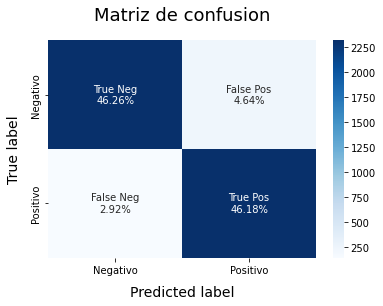

In [18]:
ConfusionMatrix(y_pred, y_test)